# Project: Write an Algorithm for a Dog Identification App 


##  Project Description
Image classification is the most simple task in computer vision. Since convolutional networks started to gain traction among both computer vision researchers and practitioners, there has been many convolutional architectures developed to conquer the classification tasks. Nowadays, the most state-of-the-art architecture likely to achieve 90% accuracy in many cases. However, in real applications, many developers/practitioners build their own models that fit their tasks rather than relying on pre-trained architectures. Therefore, it is essential to understand the ideas, key structural changes that make an architecture better than another. In this project, I want to review 3 widely used convolutional architectures, namely Resnet, InceptionV3 network, and Xception network.

Specifically, I will measure the performance of those 3 models based on a real application: classify dog breeds. There are 133 categories of dog breeds in the dataset, which is collected from the ImageNet database. The challenges come from the complexity of the classification task (i.e. number of categories), many breeds of dog look very much alike. Therefore, we need a model not only sufficiently deep to learn the difference in details of each breed, but also techniques that help the model combat training difficulties, such as training time, exploding/vanishing gradient, overfitting and so on.

The models are evaluated based on the testing accuracy, i.e. percentage of correctly labeled images out of all testing images.


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets and Data Exploration
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets and Exploration

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

#### One more thing before starting

In [1]:
'''
Comment out the code below to install/downgrade Pillow to 5.4.1, and then restart the kernel 
if there is an error saying: 
    "UnboundLocalError: local variable 'photoshop' referenced before assignment"
Ref: https://github.com/python-pillow/Pillow/pull/3771
'''

import PIL
PIL.__version__

# !pip install 'Pillow==5.4.1' --force-reinstall

You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Define Config

In [2]:
TRAIN_DIR = '../../../data/dog_images/train'
VALID_DIR = '../../../data/dog_images/valid'
TEST_DIR = '../../../data/dog_images/test'
EPOCH = 5
BATCH_SIZE = 32

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for visualize images
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from glob import glob
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(TRAIN_DIR)
valid_files, valid_targets = load_dataset(VALID_DIR)
test_files, test_targets = load_dataset(TEST_DIR)

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob(TRAIN_DIR+"/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### Take a look at the human faces

In [6]:
for i in human_files[:5]:
    img = Image.open(i)
    print(f'Human Images of size {img.size}')

Human Images of size (250, 250)
Human Images of size (250, 250)
Human Images of size (250, 250)
Human Images of size (250, 250)
Human Images of size (250, 250)


In [7]:
def display_images(files, nrow=2, ncol=3):
    '''
    Display images by nrow x ncol.
    @param files: an array of paths of the images
    '''
    fig=plt.figure(figsize=(12, 8))
    images = np.random.choice(files, ncol*nrow)
    for i in range(0, ncol*nrow):
        fig.add_subplot(nrow, ncol, i+1)
        img = mpimg.imread(images[i])
        labels = images[i].split('/')[-1]
    
        plt.imshow(img)
        plt.title(labels)
    plt.show()
    
    return

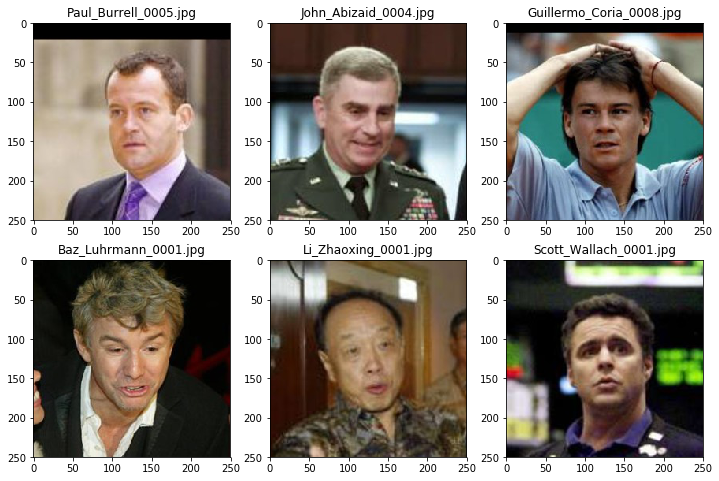

In [8]:
display_images(human_files)

### Take a look at the dog images and their breeds

Dog Images differ in sizes. Therefore we will need to crop to a fixed size for training our model later.

In [9]:
for i in train_files[:5]:
    img = Image.open(i)
    print(f'Dog Images of size {img.size}')

Dog Images of size (640, 427)
Dog Images of size (500, 332)
Dog Images of size (800, 533)
Dog Images of size (320, 320)
Dog Images of size (470, 370)


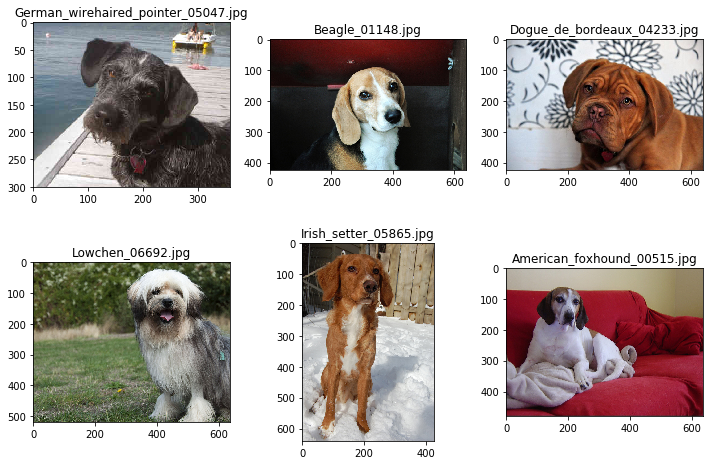

In [10]:
display_images(train_files)

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

The next code cell demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


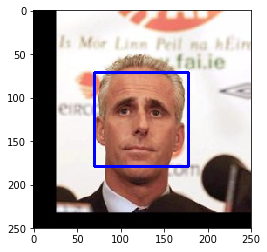

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(np.random.choice(human_files))
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [12]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [13]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.
human_count = 0
dog_count = 0

for img in human_files_short:
    human_count += face_detector(img)
    
for img in dog_files_short:
    dog_count += face_detector(img) 
    
print(f'Number of human faces detected in human files: {human_count}')
print(f'Number of human faces detected in dog files: {dog_count}')

Number of human faces detected in human files: 100
Number of human faces detected in dog files: 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ It depends on the applications. For application that needs highly accurate detector, such as security, we should set requirements for our inputs. For application that is more of entertaining purposes, users would response negatively to the product if they are required to follow a set of rules. Therefore, we need to come up with an algorithm that can detect human faces in various situations, i.e. different angles, poses, emotions, light, and so on. In that case, not only we need a more diverse dataset, augment the dataset, but also a robust model that can be trained on a big input within reasonable time limit. That's where convolutional networks come in handy.

#### Another face detector

Here I'm using another version of `haarcascades algorithms` called `haarcascade_frontalface_alt_tree`, adopted from the same `opencv` [github](https://github.com/opencv/opencv/tree/master/data/haarcascades) above.

In [14]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt_tree.xml')

human_count = 0
dog_count = 0

for img in human_files_short:
    human_count += face_detector(img)
    
for img in dog_files_short:
    dog_count += face_detector(img) 
    
print(f'Number of human faces detected in human files: {human_count}')
print(f'Number of human faces detected in dog files: {dog_count}')

Number of human faces detected in human files: 56
Number of human faces detected in dog files: 1


**Results:**

- all_tree: "Stump-based gentle adaboost, using tree of stage classifiers". This algorithm is more conservative in giving its predictions. While it made much fewer errors in the dog files, it performed worse in detecting the human faces.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [17]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [18]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [19]:
%%time

human_count = 0
dog_count = 0

for img in human_files_short:
    human_count += dog_detector(img)
    
for img in dog_files_short:
    dog_count += dog_detector(img) 
    
print(f'Number of dog faces detected in human files: {human_count}')
print(f'Number of dog faces detected in dog files: {dog_count}')

Number of dog faces detected in human files: 0
Number of dog faces detected in dog files: 100
CPU times: user 6.82 s, sys: 672 ms, total: 7.49 s
Wall time: 10.9 s


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Prepare train/valid/test set

`ImageDataGenerator` and `flow_from_directory` provide us a neat way to prepare train/valid/test set. For the training and validating generator, we use the same augmentation settings, while only normalize the testing generator.

In [20]:
from keras.preprocessing.image import ImageDataGenerator
    
# Define Generator        
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# only rescale in dev/test generator 
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define train/dev/test sets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None, # no labels
    color_mode="rgb",
    shuffle=False, # no shuffling
    seed=42
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


Model Architecture

![Sample CNN](images/sample_cnn.png)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ The hinted architecture uses the convolutional blocks of the VGG architecture, however it is much smaller in size. I also use a dropout layer in each convolutional blocks to fight overfitting. The `MaxPooling` and `GlobalAveragePooling` layers not only can help reduce the computation expense but also turn out to be very good practice as pooling layers "filter out" the most important features/details (as with `MaxPooling`) or combine the effects of surrounding features (as with `AveragePooling`) in the image.

### Model Architecture

In [21]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [24]:
model = Sequential()

# Define your architecture.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        36928     
__________

### Compile the Model

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Use model checkpointing to save the model that attains the best validation loss.

In [28]:
from keras.callbacks import ModelCheckpoint  


epochs = 3
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=500,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=200,
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/3
500/500 [==============================] - 647s 1s/step - loss: 4.8678 - acc: 0.0109 - val_loss: 4.8352 - val_acc: 0.0090
Epoch 2/3
500/500 [==============================] - 628s 1s/step - loss: 4.8005 - acc: 0.0163 - val_loss: 4.7723 - val_acc: 0.0226
Epoch 3/3
500/500 [==============================] - 637s 1s/step - loss: 4.7355 - acc: 0.0218 - val_loss: 4.7283 - val_acc: 0.0195


### Load the Model with the Best Validation Loss

In [29]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [30]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

836/836 [==============================] - 19s 22ms/step


In [47]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [48]:
# import pandas as pd
# filenames=test_generator.filenames
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions":predictions})

In [49]:
# get index of predicted dog breed for each image in test set
# dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(predicted_class_indices)==np.argmax(test_targets, axis=1)) \
                    / len(predicted_class_indices)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.8373%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [50]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [51]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [52]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [37]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 313us/step - loss: 12.7217 - acc: 0.1124 - val_loss: 11.2333 - val_acc: 0.1928
Epoch 2/20
6680/6680 [==============================] - 2s 262us/step - loss: 10.8619 - acc: 0.2448 - val_loss: 10.7452 - val_acc: 0.2563
Epoch 3/20
6680/6680 [==============================] - 2s 254us/step - loss: 10.3467 - acc: 0.3018 - val_loss: 10.5479 - val_acc: 0.2623
Epoch 4/20
6680/6680 [==============================] - 2s 253us/step - loss: 10.0767 - acc: 0.3352 - val_loss: 10.2726 - val_acc: 0.2946
Epoch 5/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.8972 - acc: 0.3557 - val_loss: 10.2690 - val_acc: 0.3018
Epoch 6/20
6680/6680 [==============================] - 2s 250us/step - loss: 9.8268 - acc: 0.3678 - val_loss: 10.2764 - val_acc: 0.3102
Epoch 7/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.7656 - acc: 0.3757 - val_loss: 10.1605 - val_ac

### Load the Model with the Best Validation Loss

In [38]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [39]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.5502%


### Predict Dog Breed with the Model

In [40]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [41]:
for i, f in enumerate(test_files[:10]):
    target_id = np.argmax(test_targets[i])
    print(f'Dog class: {dog_names[target_id]}')
    print(f'Predict: {VGG16_predict_breed(f)}')
    print()

Dog class: ages/train/057.Dalmatian
58892288/58889256 [==============================] - 1s 0us/step
Predict: ages/train/057.Dalmatian

Dog class: ages/train/059.Doberman_pinscher
Predict: ages/train/102.Manchester_terrier

Dog class: ages/train/115.Papillon
Predict: ages/train/049.Chinese_crested

Dog class: ages/train/019.Bedlington_terrier
Predict: ages/train/019.Bedlington_terrier

Dog class: ages/train/068.Flat-coated_retriever
Predict: ages/train/002.Afghan_hound

Dog class: ages/train/021.Belgian_sheepdog
Predict: ages/train/124.Poodle

Dog class: ages/train/043.Canaan_dog
Predict: ages/train/011.Australian_cattle_dog

Dog class: ages/train/052.Clumber_spaniel
Predict: ages/train/048.Chihuahua

Dog class: ages/train/097.Lakeland_terrier
Predict: ages/train/026.Black_russian_terrier

Dog class: ages/train/051.Chow_chow
Predict: ages/train/051.Chow_chow



---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [53]:
def build_bottleneck_model(model_path):  
    '''
    Build CNN model using bottleneck features of pre-trained network.
    Adding onto the bottleneck GlobalAveragePooling and a Fully Connected Network with 133 output labels.
    Train and save the best model, then give the predictions based on it.
    
    @param model_path: string, path to the bottleneck features
    @return model: trained CNN model
    @return predictions: predictions based on testing set
    '''
    # Obtain bottleneck features from another pre-trained CNN.
    model_name = model_path.split('/')[-1]
    bottleneck_features = np.load(model_path)
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']

    # Define architecture.
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
    model.add(Dropout(0.5))
    model.add(Dense(133, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{model_name}.hdf5', 
                                   verbose=1, save_best_only=True)

    model.fit(train, train_targets, 
              validation_data=(valid, valid_targets),
              epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

    # Load best model
    model.load_weights(f'saved_models/weights.best.{model_name}.hdf5')

    # Testing
    predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) 
                   for feature in test]
    
    return model, predictions

### Model Architecture

   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Here I just use the pretrained `InceptionV3` bottleneck, on top of which a `GlobalAveragePooling` and a softmax `Dense` layers are added to give the final probabilities for 133 classes. The `InceptionV3` is a very deep network, using 42 layers, including `Convolution`, `Max Pooling`, `Average Pooling`. For a complex classification task like this, we may need such a deep model. More importantly, `InceptionV3` offers a variety of brilliant techniques that help reduce the number of training parameters while still maintaining efficiency, such as `Factorizing Convolution`, `Efficient Grid Size Reduction`, and a regularization technique `Auxiliary Classifier`. Intuitively, it tells us whether the intermediate layers carry any important information, hence also help to avoid vanishing gradient. More details about [InceptionV3](https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c).



In [54]:
InceptionV3_model, preds = build_bottleneck_model('bottleneck_features/DogInceptionV3Data.npz')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 446us/step - loss: 1.5475 - acc: 0.6317 - val_loss: 0.6922 - val_acc: 0.8000
Epoch 2/20
6680/6680 [==============================] - 2s 363us/step - loss: 0.5813 - acc: 0.8268 - val_loss: 0.5941 - val_acc: 0.8335
Epoch 3/20
6680/6680 [==============================] - 2s 362us/step - loss: 0.4435 - acc: 0.8593 - val_loss: 0.6193 - val_acc: 0.8228
Epoch 4/20
6680/6680 [==============================] - 2s 361us/step - loss: 0.3553 - acc: 0.8832 - val_loss: 0.5811 - val_acc: 0.8407
Epoch 5/20
6680/6680 [==============================] - 2s 357us/step - loss: 0.2804 - acc: 0.9046 - val_loss: 0.6245 - val_acc: 0.8467
Epoch 6/20
6680/6680 [==============================] - 2s 357us/step - loss: 0.2527 - acc: 0.9144 - val_loss: 0.6713 - val_acc: 0.8455
Epoch 7/20
6680/6680 [==============================] - 2s 361us/step - loss: 0.2144 - acc: 0.9259 - val_loss: 0.6554 - val_acc: 0.8479
E

In [55]:
InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [56]:
# report test accuracy
test_accuracy = 100*np.sum(np.array(preds)==np.argmax(test_targets, axis=1)) \
                            /len(preds)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.4258%


### ResNet-50

In [58]:
# report test accuracy
model, predictions = build_bottleneck_model('bottleneck_features/DogResnet50Data.npz')
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1)) \
                            /len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 358us/step - loss: 2.3718 - acc: 0.4443 - val_loss: 0.8782 - val_acc: 0.7449
Epoch 2/20
6680/6680 [==============================] - 2s 264us/step - loss: 0.7584 - acc: 0.7660 - val_loss: 0.7601 - val_acc: 0.7892
Epoch 3/20
6680/6680 [==============================] - 2s 261us/step - loss: 0.4768 - acc: 0.8503 - val_loss: 0.6661 - val_acc: 0.7928
Epoch 4/20
6680/6680 [==============================] - 2s 263us/step - loss: 0.3459 - acc: 0.8888 - val_loss: 0.6500 - val_acc: 0.8072
Epoch 5/20
6680/6680 [==============================] - 2s 260us/step - loss: 0.2678 - acc: 0.9157 - val_loss: 0.6714 - val_acc: 0.8012
Epoch 6/20
6680/6680 [==============================] - 2s 259us/step - loss: 0.2242 - acc: 0.9283 - val_loss: 0.6710 - val_acc: 0.8000
Epoch 7/20
6680/6680 [==============================] - 2s 258us/step - loss: 0.1851 - acc: 0.9406 - val_loss: 0.6502 - val_acc: 0.8168
E

### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [59]:
from extract_bottleneck_features import *

def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    prob = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)], prob


def Resnet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    prob = np.max(predicted_vector)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)], prob

In [60]:
for i, f in enumerate(test_files[:10]):
    target_id = np.argmax(test_targets[i])
    print(f'Dog class: {dog_names[target_id]}')
    pred, prob = Resnet_predict_breed(f)
    print(f'Predict: {pred} with {prob*100}% confidence')
    print()

Dog class: ages/train/057.Dalmatian
94658560/94653016 [==============================] - 2s 0us/step
Predict: ages/train/057.Dalmatian with 99.99967813491821% confidence

Dog class: ages/train/059.Doberman_pinscher
Predict: ages/train/059.Doberman_pinscher with 64.89123702049255% confidence

Dog class: ages/train/115.Papillon
Predict: ages/train/115.Papillon with 99.45603013038635% confidence

Dog class: ages/train/019.Bedlington_terrier
Predict: ages/train/019.Bedlington_terrier with 99.39653277397156% confidence

Dog class: ages/train/068.Flat-coated_retriever
Predict: ages/train/068.Flat-coated_retriever with 97.52878546714783% confidence

Dog class: ages/train/021.Belgian_sheepdog
Predict: ages/train/021.Belgian_sheepdog with 62.852537631988525% confidence

Dog class: ages/train/043.Canaan_dog
Predict: ages/train/043.Canaan_dog with 44.01543140411377% confidence

Dog class: ages/train/052.Clumber_spaniel
Predict: ages/train/052.Clumber_spaniel with 91.13547801971436% confidence

Do

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### Write your Algorithm

In [61]:
def detector(img_path):
    '''
    Build a detector, which gives predictions of a dog breed if the image contains either dog or human.
    
    @param img_path: string, path to the input image
    '''
    has_human = face_detector(img_path)
    has_dog = dog_detector(img_path)
    pred, prob = InceptionV3_predict_breed(img_path)
    pred = pred.split('.')[-1]
    if has_human:
        print("Human detected. Predicting ...")
        print(f"Look likes: {pred} with {prob*100}% confidence")
    if has_dog:
        print("Dog detected. Predicting ...")
        print(f"Breed: {pred} with {prob*100}% confidence")
    if not has_human and not has_dog:
        print("No human or dog detected. Please upload another image")

    return


In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
    
def display_image(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return

Human Image 1


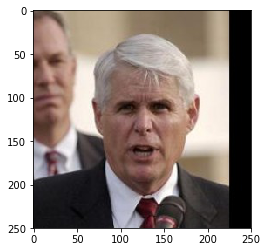

87916544/87910968 [==============================] - 1s 0us/step
Human detected. Predicting ...
Look likes: Afghan_hound with 13.807083666324615% confidence

Human Image 2


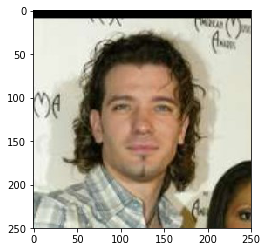

Human detected. Predicting ...
Look likes: Dachshund with 13.159355521202087% confidence

Human Image 3


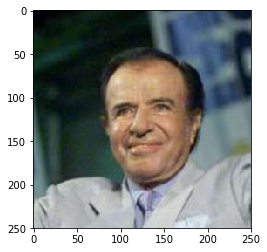

Human detected. Predicting ...
Look likes: Parson_russell_terrier with 11.065123230218887% confidence

Human Image 4


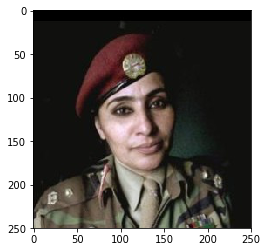

No human or dog detected. Please upload another image

Human Image 5


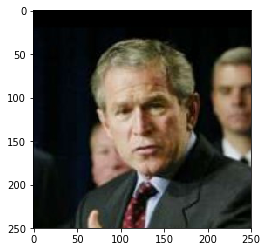

Human detected. Predicting ...
Look likes: Dachshund with 12.803764641284943% confidence

Human Image 6


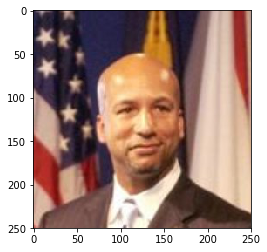

Human detected. Predicting ...
Look likes: Curly-coated_retriever with 23.954154551029205% confidence

Human Image 7


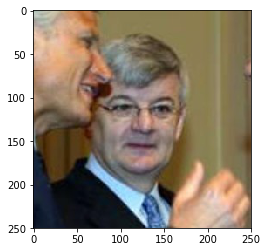

No human or dog detected. Please upload another image

Human Image 8


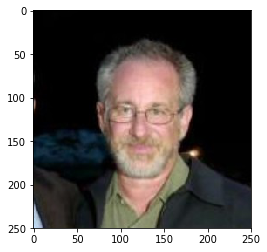

No human or dog detected. Please upload another image

Human Image 9


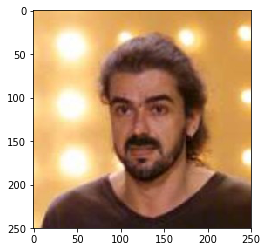

Human detected. Predicting ...
Look likes: Dachshund with 14.308267831802368% confidence

Human Image 10


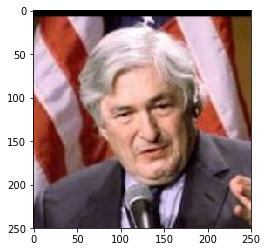

No human or dog detected. Please upload another image



In [63]:
for i, f in enumerate(human_files_short[:10]):
    print(f'Human Image {i+1}')
    display_image(f)
    detector(f)
    print()

Dog Image 1


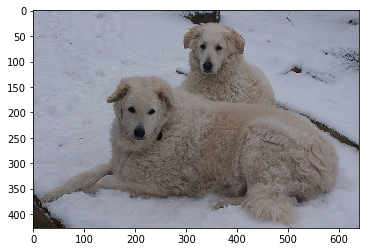

Dog detected. Predicting ...
Breed: Kuvasz with 99.94494318962097% confidence

Dog Image 2


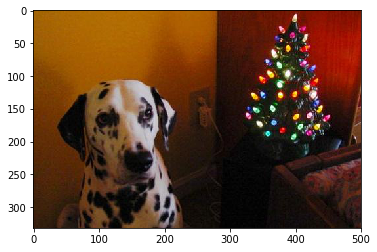

Dog detected. Predicting ...
Breed: Dalmatian with 99.95669722557068% confidence

Dog Image 3


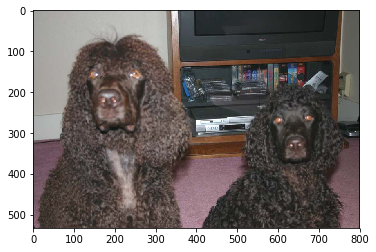

Dog detected. Predicting ...
Breed: Irish_water_spaniel with 96.44976258277893% confidence

Dog Image 4


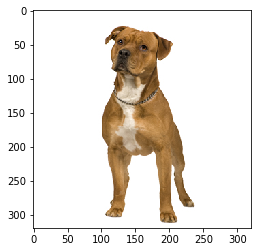

Dog detected. Predicting ...
Breed: American_staffordshire_terrier with 97.26319313049316% confidence

Dog Image 5


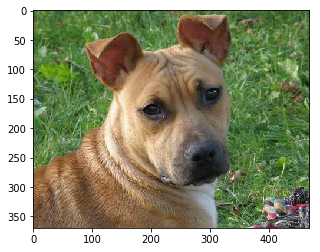

Dog detected. Predicting ...
Breed: American_staffordshire_terrier with 99.44530129432678% confidence

Dog Image 6


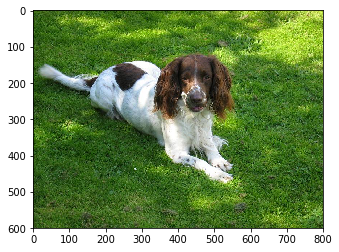

Dog detected. Predicting ...
Breed: Irish_red_and_white_setter with 78.20573449134827% confidence

Dog Image 7


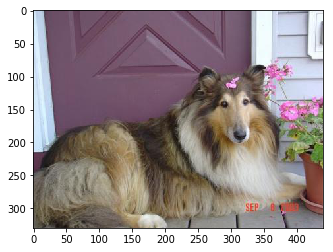

Dog detected. Predicting ...
Breed: Collie with 99.98725652694702% confidence

Dog Image 8


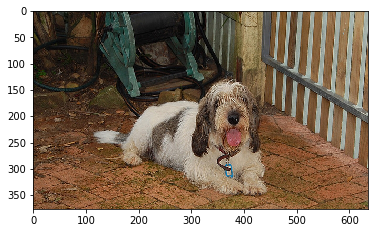

Dog detected. Predicting ...
Breed: Petit_basset_griffon_vendeen with 97.881680727005% confidence

Dog Image 9


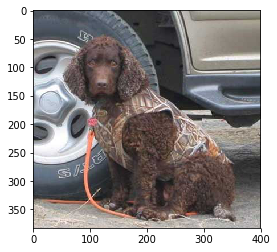

Dog detected. Predicting ...
Breed: American_water_spaniel with 98.60880970954895% confidence

Dog Image 10


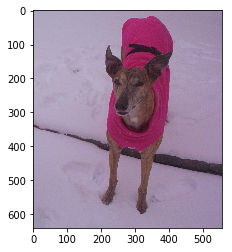

Dog detected. Predicting ...
Breed: Greyhound with 94.51202154159546% confidence



In [64]:
for i, f in enumerate(dog_files_short[:10]):
    print(f'Dog Image {i+1}')
    display_image(f)
    detector(f)
    print()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The result is pretty good. Even though just 2 out of 5 dog images are classified correctly, the wrong ones are very challenging even for human. For example, Siberian Husky and Alaska Malamute are very much similar. Also, the model predicts with very high confidence, meaning it learned the features of the dog breeds. For future work, things that should be considered:

- Training some of the last layers of the bottleneck, instead of using all pre-trained weights
- Tuning hyperparameters, learning rate scheduler, better augmentation technique
- Another architecture such as Xception, or Inception-Resnet

1: images/test/got.jpg


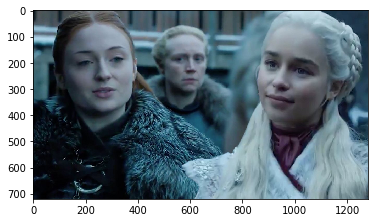

Human detected. Predicting ...
Look likes: Dachshund with 28.3078670501709% confidence

2: images/test/siberian-husky2.jpg


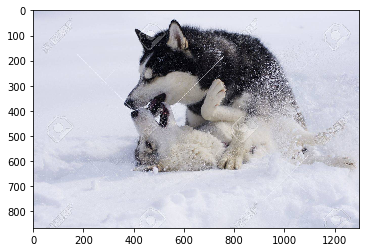

Dog detected. Predicting ...
Breed: Alaskan_malamute with 99.56306219100952% confidence

3: images/test/Siberian-Husky.jpg


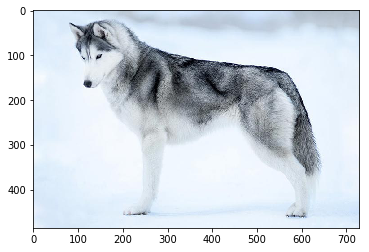

Dog detected. Predicting ...
Breed: Alaskan_malamute with 98.82436990737915% confidence

4: images/test/German-Shepherd.jpg


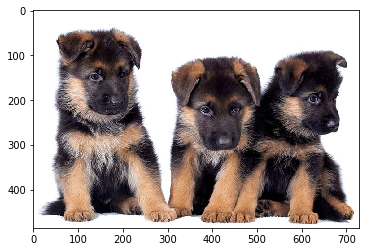

Dog detected. Predicting ...
Breed: Belgian_tervuren with 69.8319673538208% confidence

5: images/test/knight-king.jpg


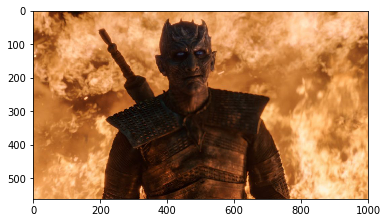

No human or dog detected. Please upload another image

6: images/test/Alaskan-Malamute.jpg


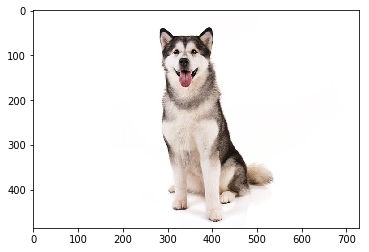

Dog detected. Predicting ...
Breed: Alaskan_malamute with 99.903404712677% confidence

7: images/test/Shih Tzu.jpg


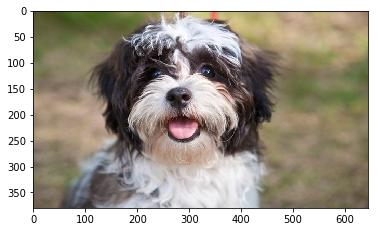

Dog detected. Predicting ...
Breed: Lhasa_apso with 51.60127282142639% confidence



In [65]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

test_images = np.array(glob("images/test/*"))
for i, f in enumerate(test_images):
    print(f'{i+1}: {test_images[i]}')
    display_image(f)
    detector(f)
    print()